In [1]:
import glob
import pandas as pd
import os

path = "../../Telemetry"
all_files = glob.glob(path + "/*.csv")

if not all_files:
    print(f"No CSV files found in {os.path.abspath(path)}. Ensure the files are placed correctly.")
else:
    combined_csv = pd.concat([pd.read_csv(file) for file in all_files])
    combined_csv.to_csv("telemetry.csv", index=False)


In [21]:
import pandas as pd

# Define fraction of telemetry data to use
sample_fraction = 0.02

# Read and preprocess the first dataset
df1 = pd.read_csv("../../PitStops/Real_Pit_Stop_Data_3.csv")
df1['Lap Stop'] = pd.to_numeric(df1['Lap Stop'], errors='coerce')
df1['Processed_GrandPrix'] = df1['Grand Prix'].str.split(',').str[0].str.strip()

# Read telemetry dataset and sample only 10%
telemetry_sample = pd.read_csv("telemetry.csv").sample(frac=sample_fraction, random_state=42)

# Preprocess telemetry data
telemetry_sample['LapNumber'] = pd.to_numeric(telemetry_sample['LapNumber'], errors='coerce')
telemetry_sample['Processed_RaceName'] = telemetry_sample['RaceName'].str.extract(r'(.*?) Grand Prix')

# Merge the sampled telemetry data with the first dataset
merged_df = pd.merge(
    df1,
    telemetry_sample,
    left_on=['Processed_GrandPrix', 'Lap Stop'],
    right_on=['Processed_RaceName', 'LapNumber'],
    how='inner'  # Adjust merge type as needed
)

# Drop unnecessary columns
merged_df.drop(columns=['Processed_GrandPrix', 'Processed_RaceName'], inplace=True)

# Output the final merged DataFrame
print(merged_df)


       Grand Prix  Race                       Circuit   Year  \
0         Bahrain     3  Bahrain International Circuit  2014   
1         Bahrain     3  Bahrain International Circuit  2014   
2         Bahrain     3  Bahrain International Circuit  2014   
3         Bahrain     3  Bahrain International Circuit  2014   
4         Bahrain     3  Bahrain International Circuit  2014   
...           ...   ...                            ...   ...   
400817     Sakhir    16  Bahrain International Circuit  2020   
400818     Sakhir    16  Bahrain International Circuit  2020   
400819     Sakhir    16  Bahrain International Circuit  2020   
400820     Sakhir    16  Bahrain International Circuit  2020   
400821     Sakhir    16  Bahrain International Circuit  2020   

                Driver_x  Stop   Lap Stop    Time_x Duration          Winner  \
0       Jean-Eric Vergne      1         1  18:06:44   33.895  Lewis Hamilton   
1       Jean-Eric Vergne      1         1  18:06:44   33.895  Lewis Ham

In [22]:
merged_df.to_csv("merged_telemetry_and_pitstop.csv")

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv("merged_telemetry_and_pitstop.csv").drop(columns=['Unnamed: 10', 'Unnamed: 11'])


# Separate numeric and non-numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = data.select_dtypes(exclude=['float64', 'int64']).columns

# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
numeric_data = pd.DataFrame(imputer.fit_transform(data[numeric_columns]), columns=numeric_columns)

# Encode `RaceName` (One-Hot Encoding)
encoder_race = OneHotEncoder(drop='first', sparse_output=False)
encoded_race_names = pd.DataFrame(
    encoder_race.fit_transform(data[['RaceName']]),
    columns=encoder_race.get_feature_names_out(['RaceName'])
)

# Encode `Driver_x` (One-Hot Encoding)
encoder_driver = OneHotEncoder(drop='first', sparse_output=False)
encoded_driver_names = pd.DataFrame(
    encoder_driver.fit_transform(data[['Driver_x']]),
    columns=encoder_driver.get_feature_names_out(['Driver_x'])
)

# Combine processed data
processed_data = pd.concat([numeric_data, encoded_race_names, encoded_driver_names], axis=1)

# Define features (X) and target (y)
X = processed_data.drop(columns=['Lap Stop', 'LapNumber', 'Stop ', 'Unnamed: 0'], errors='ignore')
y = processed_data['Lap Stop']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


/var/folders/7q/w_k7x3ss7fsgflp_442s596r0000gn/T/ipykernel_1065/432924907.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("merged_telemetry_and_pitstop.csv").drop(columns=['Unnamed: 10', 'Unnamed: 11'])


Mean Squared Error: 90.35634497267696
R^2 Score: 0.5119607644844301


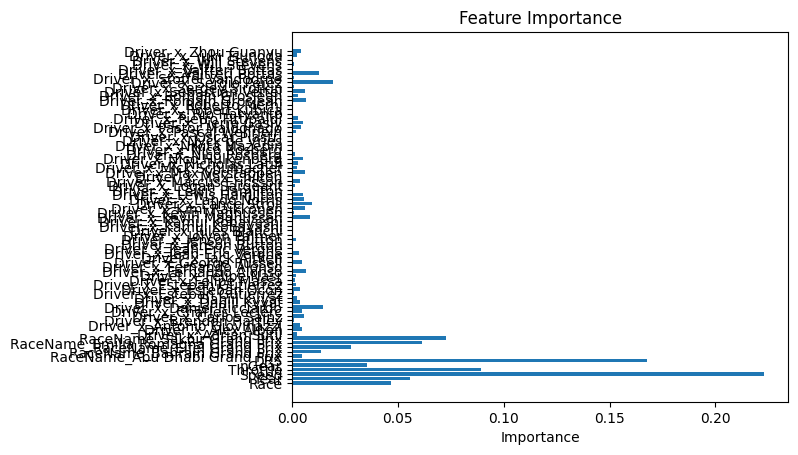

In [27]:
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
plt.barh(X.columns, feature_importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()


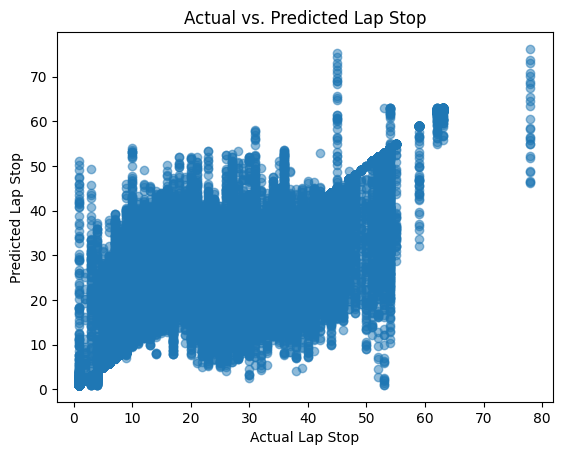

In [28]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Lap Stop")
plt.ylabel("Predicted Lap Stop")
plt.title("Actual vs. Predicted Lap Stop")
plt.show()


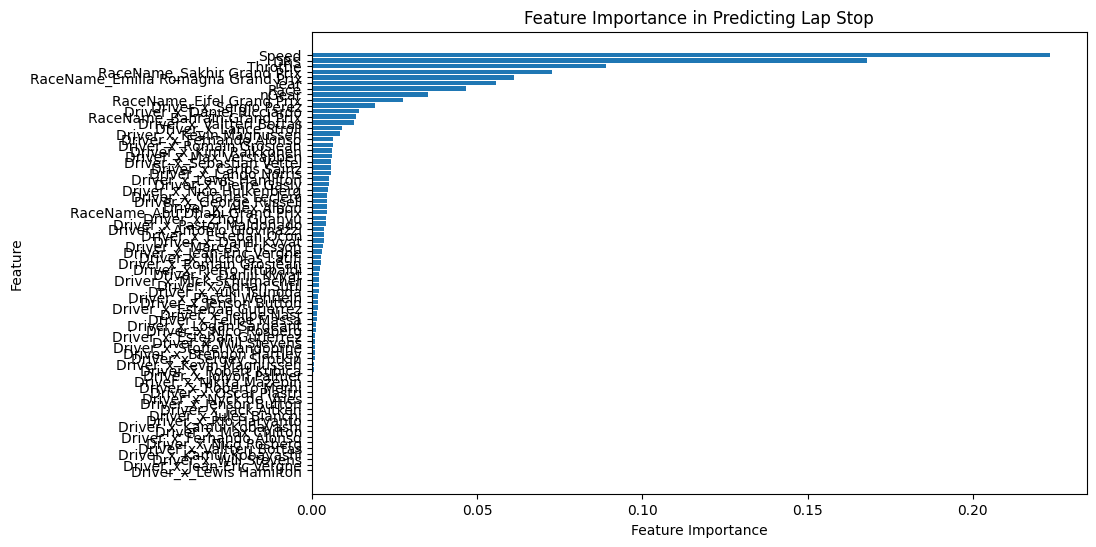

In [29]:
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting Lap Stop")
plt.gca().invert_yaxis()
plt.show()


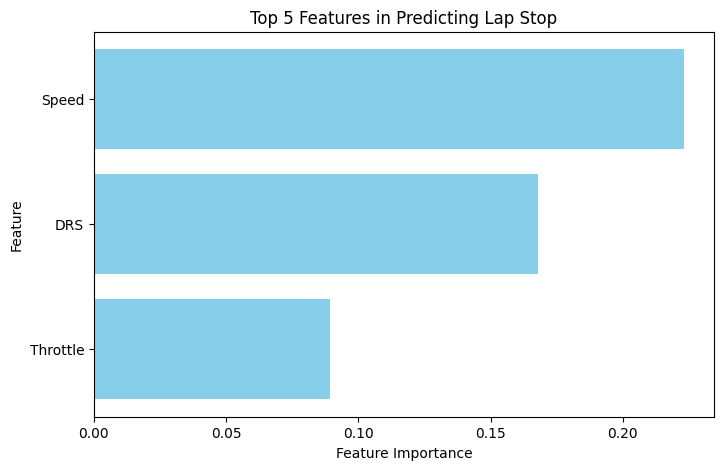

In [52]:
# Sort and select the top 5 features
top_features = importance_df.head(3)

# Plot feature importance for top 5 features
plt.figure(figsize=(8, 5))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 5 Features in Predicting Lap Stop")
plt.gca().invert_yaxis()
plt.show()


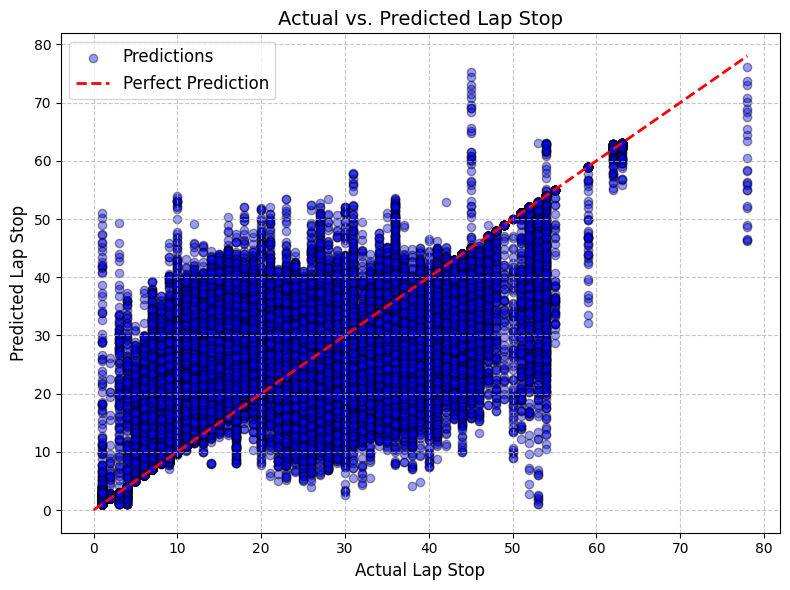

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Plot
plt.figure(figsize=(8, 6))  # Larger figure size
plt.scatter(y_test, y_pred, alpha=0.4, c='blue', edgecolor='k', label='Predictions')

# Add a line representing perfect predictions
max_value = max(max(y_test), max(y_pred))
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

# Add titles and labels
plt.title('Actual vs. Predicted Lap Stop', fontsize=14)
plt.xlabel('Actual Lap Stop', fontsize=12)
plt.ylabel('Predicted Lap Stop', fontsize=12)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=12)

# Add tick parameters
plt.tick_params(axis='both', which='major', labelsize=10)

# Show the plot
plt.tight_layout()
plt.show()


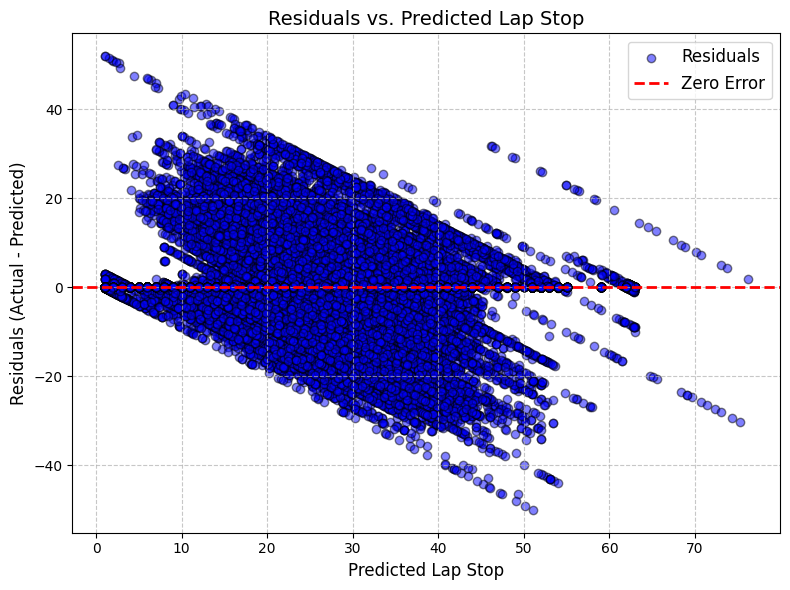

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals vs predicted
plt.figure(figsize=(8, 6))  # Larger figure size
plt.scatter(y_pred, residuals, alpha=0.5, c='blue', edgecolor='k', label='Residuals')

# Add a horizontal line at residuals = 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')

# Add titles and labels
plt.title('Residuals vs. Predicted Lap Stop', fontsize=14)
plt.xlabel('Predicted Lap Stop', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=12)

# Add tick parameters
plt.tick_params(axis='both', which='major', labelsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [33]:
data['Avg_Speed_Upto_Lap'] = data.groupby('RaceName')['Speed'].cumsum() / data['LapNumber']
race_mean_stop = data.groupby('RaceName')['Lap Stop'].mean()
data['Race_Target_Enc'] = data['RaceName'].map(race_mean_stop)

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Example DataFrame
data = {
    'feature1': ['A', 'B', 'A', 'C', 'B', 'C'],
    'feature2': [10, 20, 10, 30, 20, 30],
    'feature3': ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06'],
    'label': [1, 0, 1, 0, 1, 0]
}
df = pd.DataFrame(data)

# Convert 'feature3' to datetime
df['feature3'] = pd.to_datetime(df['feature3'])

# Split data into features and labels
X = df.drop(columns=['label'])
y = df['label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Separate numeric and non-numeric columns
non_numeric_columns = X_train.select_dtypes(include=['object', 'datetime']).columns
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# Scale numeric columns
scaler = StandardScaler()
X_train_numeric = pd.DataFrame(
    scaler.fit_transform(X_train[numeric_columns]),
    columns=numeric_columns,
    index=X_train.index
)
X_test_numeric = pd.DataFrame(
    scaler.transform(X_test[numeric_columns]),
    columns=numeric_columns,
    index=X_test.index
)

# Encode non-numeric columns with OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[non_numeric_columns])

X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[non_numeric_columns]),
    columns=encoder.get_feature_names_out(non_numeric_columns),
    index=X_train.index
)
X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[non_numeric_columns]),
    columns=encoder.get_feature_names_out(non_numeric_columns),
    index=X_test.index
)

# Combine numeric and encoded non-numeric columns
X_train_processed = pd.concat([X_train_numeric, X_train_encoded], axis=1)
X_test_processed = pd.concat([X_test_numeric, X_test_encoded], axis=1)

# Verify processed data
print("X_train_processed:")
print(X_train_processed)
print("\nX_test_processed:")
print(X_test_processed)


X_train_processed:
   feature2  feature1_B  feature1_C  feature3_2022-01-04T00:00:00.000000000  \
5  0.904534         0.0         1.0                                     0.0   
2 -1.507557         0.0         0.0                                     0.0   
4 -0.301511         1.0         0.0                                     0.0   
3  0.904534         0.0         1.0                                     1.0   

   feature3_2022-01-05T00:00:00.000000000  \
5                                     0.0   
2                                     0.0   
4                                     1.0   
3                                     0.0   

   feature3_2022-01-06T00:00:00.000000000  
5                                     1.0  
2                                     0.0  
4                                     0.0  
3                                     0.0  

X_test_processed:
   feature2  feature1_B  feature1_C  feature3_2022-01-04T00:00:00.000000000  \
0 -1.507557         0.0         0.0      

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


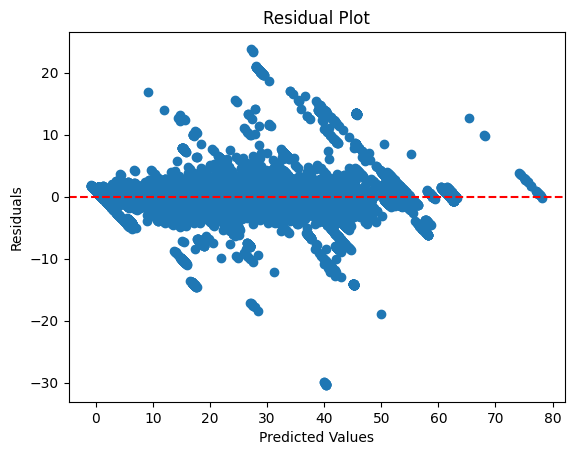

In [45]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


In [46]:
# Load holdout data
holdout_data = pd.read_csv("holdout_data.csv")

# Preprocess holdout data (same steps as original data)
# ...

# Predict and evaluate on holdout data
y_holdout_pred = model.predict(X_holdout).flatten()
holdout_mse = mean_squared_error(y_holdout, y_holdout_pred)
holdout_r2 = r2_score(y_holdout, y_holdout_pred)

print(f"Holdout MSE: {holdout_mse}")
print(f"Holdout R^2: {holdout_r2}")


FileNotFoundError: [Errno 2] No such file or directory: 'holdout_data.csv'